# 3. Calidad de un Vino
Dentro de las variedades del vino, existen distintas calidades de este, donde algunos gustan mas a algunas
personas que otras, esto depende de la gran cantidad de quı́micos y procesos que se aplican a la producción
de vino. Para el área de negocios el estimar cuál es la calidad del vino en base a la apreciación de la gente es
una tarea bastante difı́cil.


Para esta actividad se trabajará con dos datasets asociados a variantes tinto y blanco del vino Portugués
"Vinho Verde"[4]. Debido a temas privados solo se cuenta atributos fisioquı́micos asociados a un vino en
particular, los cuales corresponden a 11 atributos numéricos descritos en el siguiente link.

Este problema puede ser abordado como clasificación de 11 clases o de regresión, ya que el atributo a estimar,
la calidad quality, es un valor entero entre 0 y 10.

## (a)
Carge los dos dataset en un único dataframe de pandas, además de agregar una columna indicando si
es vino tinto o blanco. Describa el dataset a trabajar.

In [168]:
import pandas as pd
import numpy as np

df_red = pd.read_csv('winequality-red.csv', sep=';')
df_white = pd.read_csv('winequality-white.csv', sep=';')
df = pd.concat([df_red, df_white], axis=0)
# genere atributo 'tipo'

In [169]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Las características del dataset son atributos químicos relacionados con el vino, por lo cual son todos atributos continuos que pueden variar en diversos rangos. Debido a que se utilizarán árboles de clasificación; en conjunto con los respectivos ensamblados que utilizan estos clasificadores, no es fundamental el preprocesar la data para centrarla o escalarla, ya que estos clasificadores son insensibles ante tales transformaciones.

## (b)
Aborde este problema como si fuera de clasificación binaria para predecir si un vino es de calidad o
no, es decir, utilice las distintas caracterı́sticas fisioquı́micas presentes en los datos para estimar esta
etiqueta. Para esto cree las matrices de entrenamiento y de pruebas, además de la etiqueta para ambos
conjuntos, considerando como quality mayor a 5 un vino de buena calidad. El conjunto de pruebas
($25 \%$) será utilizado únicamente para verificar la calidad de los algoritmos a entrenar.

Para poder estimar con mayor significancia estadística la capacidad de generalización de los diversos algoritmos, se han generado 20 conjuntos de train y test a partir de todos los datos que se tienen disponibles; es decir, se ha mezclado el train y test set originales y a partir de 20 remuestreos se han generado los nuevos conjuntos. Esto reduce la posibilidad de que se concluya erróneamente que un algoritmo tiene mejor capacidad de generalización que los demás debido tan sólo a un conjunto de train y test que le son favorables.

In [170]:
from sklearn.model_selection import train_test_split

df['good_quality'] = [1 if q > 5 else 0 for q in df.quality]
# train and test split over df
y = df['good_quality']
df = df.drop(['good_quality'],axis=1)
df = df.drop(['quality'],axis=1)

Train_sets = []
Test_sets = []
Train_y = []
Test_y = []

#Construccion de 20 sets de train y test para estimar con mayor significancia estadística el error de generalización
for i in range(20):
    
    X_train,X_test,y_train,y_test = train_test_split(df,y,test_size=0.25)
    Train_sets.append(X_train)
    Test_sets.append(X_test)
    Train_y.append(y_train)
    Test_y.append(y_test)


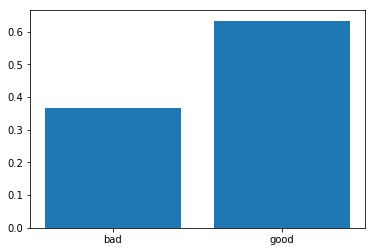

In [177]:
qcount = []
qcount.append(np.sum(y==1)/len(y))
qcount.append(np.sum(y==0)/len(y))
x = ["good","bad"]
plt.bar(x,qcount)
plt.show()


Se observa además que tenemos un problema de clases desbalanceadas: aproximadamente el 37% de los datos corresponden a la clase de vino malo, mientras que el resto pertenece a la clase de vino bueno. Si bien hay que tener esto en consideración a la hora de entrenar los clasificadores, se debe notar que el desbalanceo no es tan pronunciado como en otros casos en los que clasificando una sola clase se podrían obtener accuracies de más del 90%. Aún así, se debe tener en cuenta este fenómeno a la hora de entrenar los clasificadores y/o de reportar sus métricas de desempeño.

## (c)
Entrene un solo Árbol de Clasificación de múltiples niveles para resolver el problema. Puede variar los
hiper-parámetros que prefiera, recuerde que las decisiones no pueden ser basadas mirando el conjunto
de pruebas. Debido al desbalanceo que se produce en las dos clases mida la métrica F1-score [5] sobre
el conjunto de entrenamiento y de pruebas.

Para abordar éste y los problemas que siguen, se ha implementado una función llamada "train_and_test", la cual recibe los conjuntos de train y test con sus respectivas etiquetas, una lista de parámetros asociada al algoritmo de aprendizaje, el algoritmo de aprendizaje propiamente tal dentro de una función lambda que recibe la lista de parámetros, y una función de métrica que retorna la métrica deseada asociada al conjunto de train y test. Esta función realiza cross-validation sobre cada uno de los conjuntos de entrenamiento con tal de determinar cuál es la combinación de parámetros que produce, en promedio, la arquitectura del modelo con la mejor capacidad de generalización para el problema. Luego, eligiendo tal combinación de parámetros se evalúa sobre el test set correspondiente y se obtiene la métrica deseada. 

La métrica escogida es la F-measure ponderada, la cual se obtiene a partir de considerar a cada clase como la positiva, obteniendo sus F-measures y ponderándolas teniendo en cuenta la proporción de las clases con tal de que sea una métrica balanceada.

En este caso, los resultados se reportan utilizando boxplots para resumir los resultados obtenidos sobre el conjunto de train y test.

In [95]:
from sklearn.model_selection import cross_val_score
def train_and_test(Train_sets,Test_sets,Train_y,Test_y, parameter_list,lambda_model,metrics):
    
    results_train = []
    results_test = []
    list_selected_params = []
    # Construimos una matriz que contiene todas las posibles combinaciones de parámetros
    L = len(parameter_list)
    packed_values = np.meshgrid(*parameter_list)
    
    values = []
    for i in range(L):
        values.append(packed_values[i].reshape(-1,1))
    
    parameters = np.concatenate(values,axis=1)
    
    P = parameters.shape[0]
    
    # Iteramos por cada Train y Test set
    
    for s in range(len(Train_sets)):
        
        print(s)
        # Se construye el vector que almacena los valores del CV
        grid = np.zeros(P)
        
        # Se itera por la grilla de parámetros realizando Cross-Validation
        #print(parameters)
        for i in range(P):
            clf = lambda_model(*parameters[i,:])
            grid[i] = np.mean(cross_val_score(clf, Train_sets[s], Train_y[s], cv=5))
                
        # Se escoge la mejor combinación de parámetros
        index = np.argmax(grid)
        selected_params = parameters[index,:]
        
        list_selected_params.append(selected_params)
        
        # Se entrena el modelo final
        clf = lambda_model(*selected_params)
        clf.fit(Train_sets[s],Train_y[s])
        
        y_train_pred = clf.predict(Train_sets[s])
        y_test_pred = clf.predict(Test_sets[s])
    
        # Se calcula la metrica deseada
        temp_result_train,temp_result_test = metrics(y_train_pred,Train_y[s],y_test_pred,Test_y[s])
        results_train.append(temp_result_train)
        results_test.append(temp_result_test)
    return results_train,results_test,list_selected_params

In [96]:
from sklearn.metrics import f1_score



def f_measure(y_train_pred,y_train,y_test_pred,y_test): 
    
    f_scores_train=[]
    f_scores_test=[]
    
    f_scores_train.append(f1_score(y_train, y_train_pred,average='weighted'))
    
    f_scores_test.append(f1_score(y_test,y_test_pred,average='weighted'))
    
    return f_scores_train,f_scores_test


Los parámetros del árbol que se varían son los siguientes:

- Impureza: gini o entropía. Corresponde a la medida de impureza que se utiliza para decidir, en cada paso de la construcción del árbol, qué característica se debe particionar.
- Balanceo de clases: Balanceado o nada. Corresponde tomar en consideración el desbalanceo de clases a la hora de construir el árbol: la medida de impureza se pondera de acuerdo al peso de las clases.
- Máxima profundidad: 10, 20, 50 o 100. Corresponde a la máxima profundidad que puede tomar el árbol. A mayor profundidad, más factible es que se produzca overfitting.

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

# Parámetros

criterion = ["gini","entropy"]
class_weight=[None,"balanced"]
max_depth = [10,20,50,100]

grid = np.zeros((len(criterion),len(class_weight),len(max_depth)))



for ct,i in zip(criterion,range(len(criterion))):
    for cw,j in zip(class_weight,range(len(class_weight))):
        for md,k in zip(max_depth,range(len(max_depth))):
            
            clf = DecisionTreeClassifier(max_depth=md,class_weight=cw,criterion=ct)
            grid[i,j,k] = np.mean(cross_val_score(clf, Train_sets[0], Train_y[0], cv=5))

indexes = np.unravel_index(grid.argmax(), grid.shape)





In [100]:
lambda_tree = lambda ct,cw,md: DecisionTreeClassifier(max_depth=md,class_weight=cw,criterion=ct)

In [101]:
parameter_list = [criterion,class_weight,max_depth]
results_train,results_test,selected_params = train_and_test(Train_sets,Test_sets,Train_y,Test_y, parameter_list,lambda_tree,f_measure)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


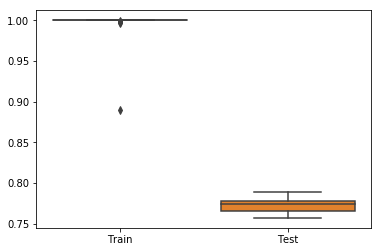

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
data = np.concatenate((results_train,results_test),axis=1)
df = pd.DataFrame(data,columns=["Train","Test"])
ax = sns.boxplot(data=df)
plt.show()

Se observa en los boxplots de la métrica F-measure de train y test que hay un claro sobreajuste al momento de entrenar los árboles de decisión: en promedio, la F-measure sobre los conjuntos de entrenamiento es 1 mientras que, calculada sobre los conjuntos de test, es de aproximadamente 0.77. Además, hay mayor variación de los resultados sobre los conjuntos de test, mientras que en el conjunto de entrenamiento la variación es casi nula. Era de esperar que los árboles sobre-ajustaran, ya que permiten la construcción de fronteras de decisión no-lineales altamente complejas que pueden terminar clasificando perfectamente todos los datos si es que se deja que el árbol crezca sin control.

A continuación se muestran histogramas acerca de los parámetros escogidos:

In [191]:
selected_criterion = [s[0] for s in selected_params]
selected_weight = [s[1] for s in selected_params]
selected_depth = [s[2] for s in selected_params]

criterion_count = [selected_criterion.count(c) for c in criterion]
weight_count = [selected_weight.count(w) for w in class_weight]
depth_count = [selected_depth.count(d) for d in max_depth]

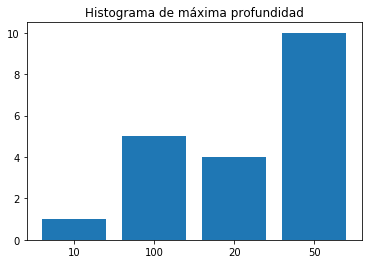

In [203]:
plt.bar(["10","20","50","100"],depth_count)
plt.title("Histograma de máxima profundidad")
plt.show()

Se observa que todas las profundidades máxima de árbol son escogidas al menos una vez. En particular, máxima profundidad 50 es la más seleccionada. Ahora, esto no nos dice la altura real de los árboles, pero es un indicador del rango en el que éstos se encuentran.

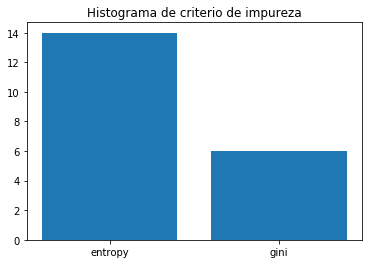

In [202]:
plt.bar(criterion,criterion_count)
plt.title("Histograma de criterio de impureza")
plt.show()

Se observa que, dentro de las combinaciones de parámetros, el criterio de división utilizado al fragmentar el árbol que más fue escogido realizando cross-validation fue el de Entropía, a pesar de que Gini es generalmente más utilizado cuando se tiene desbalanceo de clases.

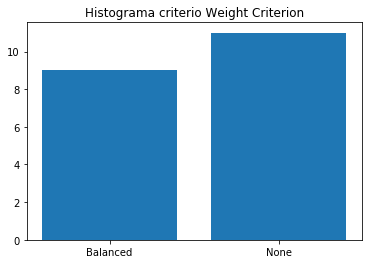

In [201]:
plt.bar(["None","Balanced"],weight_count)
plt.title("Histograma criterio Weight Criterion")
plt.show()

Se observa que tanto el criterio Balanceado como ningún criterio son escogidos en cuanto a la ponderación de las clases a la hora de entrenar los árboles. Debido a que este criterio influye en cómo se pondera la disminución de la impureza del árbol al dividir en ciertas características, está muy relacionado con el criterio de impureza utilizado (Gini o Entropía). Puede ser que en los casos en donde se escogió el criterio de balanceo, también fue escogido el criterio de Entropía, mientras que el criterio normal es escogido con el criterio Gini. Esto, sin embargo, es tan sólo especular, ya que hay que tener en consideración todos los factores y cómo se fueron dando en conjunto para poder concluir correctamente acerca de cuáles son los mejores parámetros dada la distribución de los datos. Además, con tan sólo 20 conjuntos de train test, es difícil observar la verdadera tendencia de los parámetros ya que se tienen muchas posibles combinaciones. A partir de ahora no se harán más análisis de los parámetros ideales pues consideramos que no es tan importante: lo importante es que el algoritmo de entrenamiento sea capaz de encontrar estos parámetros dado el train set que se le presenta.

## (d)
Entrene un ensamblador de árboles de múltiples niveles, mediante la técnica de Random Forest. Varı́e la
cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen
del F1-score de entrenamiento y de pruebas en función de este hiper-parámetro.

Se consideran 1, 5, 10, 15, 20, 25 y 30 árboles para el ensamblado. Los parámetros que se varían sobre el conjunto de árboles son los mismos que en la pregunta anterior. La métrica para reportar el error nuevamente es la F-measure ponderada considerando el desbalanceo de las clases. En este caso, los resultados se reportan a través de un gráfico que muestra cómo varía la F-measure promedio en los conjuntos de train y set al aumentar la cantidad de árboles del ensamblado. También se reporta la desviación estándar en este mismo gráfico.

In [205]:
from sklearn.ensemble import RandomForestClassifier
number_trees = [1,5,10,15,20,25,30]
lambda_random_forest = lambda ne,ct,cw,md: RandomForestClassifier(n_estimators=ne,max_depth=md,class_weight=cw,criterion=ct)
mean_results_train = []
std_results_train = []
mean_results_test = []
std_results_test = []

for ne in number_trees:
    print(ne)
    parameter_list = [[ne],criterion,class_weight,max_depth]
    results_train,results_test,_ = train_and_test(Train_sets,Test_sets,Train_y,Test_y, parameter_list,lambda_random_forest,f_measure)
    
    mean_results_train.append(np.mean(results_train))
    std_results_train.append(np.std(results_train))
    mean_results_test.append(np.mean(results_test))
    std_results_test.append(np.std(results_test))

1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


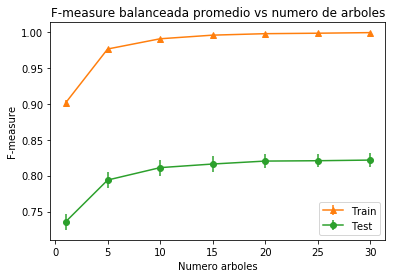

In [206]:

#plt.plot(number_trees,mean_results_train)
plt.errorbar(number_trees,mean_results_train,std_results_train, marker='^',label="Train")

plt.errorbar(number_trees,mean_results_test,std_results_test,marker='o',label="Test")
plt.legend()
plt.title("F-measure balanceada promedio vs numero de arboles")
plt.xlabel("Numero arboles")
plt.ylabel("F-measure")
plt.show()

Se observa a partir del gráfico cómo mejora la F-measure sobre los conjuntos de train y test a medida que se aumenta la cantidad de árboles de clasificación. Se observa que la calidad de la clasificación mejora hasta ser 1, en promedio, en los conjuntos de train, pero que llega hasta aproximadamente 0.82 en promedio sobre los conjuntos de test. Probablemente esto indica que 0.82 es, aproximadamente, lo máximo a lo que se podría llegar en cuanto a error de generalización de los modelos dada la cantidad disponible de datos y los atributos que estos tienen. En este caso, debido a que cuando la F-measure ponderada sobre los conjuntos de train aumenta también lo hace esta métrica sobre los conjuntos del test, se puede argumentar que, coincidentemente, la frontera de decisión que mejor separa los datos en el train también produce la mejor capacidad de generalización. Esto, por lo general, no es así, y debe entenderse que es una particularidad de los datos utilizados para este ejercicio: en otros casos, probablemente una frontera de decisión perfecta sobre el train set produzca un peor resultado sobre el test set que una frontera con cierta holgura.

## (e)
Entrene un ensamblador de árboles de múltiples niveles, mediante la técnica de AdaBoost. Varı́e la
cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen
del F1-score de entrenamiento y de pruebas en función de este hiper-parámetro. Compare y analice con
la técnica utilizada en d).

La cantidad de árboles que se probarán son nuevamente 1, 5, 10, 15, 20, 25, y 30. Los parámetros de los árboles son los mismos que se han utilizado a lo largo de esta sección.

In [109]:
from sklearn.ensemble import AdaBoostClassifier

number_trees = [1,5,10,15,20,25,30]
lambda_adaboost = lambda ne,ct,cw,md: AdaBoostClassifier(base_estimator=lambda_tree(ct,cw,md),n_estimators=ne)
mean_results_train2 = []
std_results_train2 = []
mean_results_test2 = []
std_results_test2 = []

for ne in number_trees:
    print(ne)
    parameter_list = [[ne],criterion,class_weight,max_depth]
    results_train,results_test,_ = train_and_test(Train_sets,Test_sets,Train_y,Test_y, parameter_list,lambda_adaboost,f_measure)
    
    mean_results_train2.append(np.mean(results_train))
    std_results_train2.append(np.std(results_train))
    mean_results_test2.append(np.mean(results_test))
    std_results_test2.append(np.std(results_test))

1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


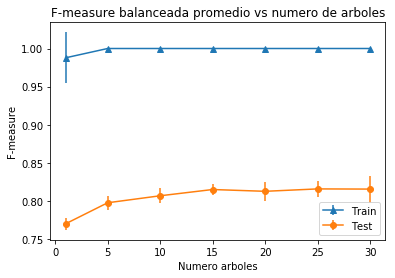

[0.77006631580672391,
 0.7976131002811907,
 0.80677986052522299,
 0.81499473704229108,
 0.81264506079064369,
 0.81579119520854371,
 0.81555875795778088]

In [110]:

#plt.plot(number_trees,mean_results_train)
plt.errorbar(number_trees,mean_results_train2,std_results_train2, marker='^',label="Train")

plt.errorbar(number_trees,mean_results_test2,std_results_test2,marker='o',label="Test")
plt.legend()
plt.title("F-measure balanceada promedio vs numero de arboles")
plt.xlabel("Numero arboles")
plt.ylabel("F-measure")
plt.show()
mean_results_test2

Nuevamente se observa que a medida que aumentan los árboles de clasificación, la F-measure ponderada promedio sobre los conjuntos de test aumenta.En este caso, sin embargo, debido a la elección de parámetros óptimos utilizando cross-validation, se obtiene una F-measure de 1 para los conjuntos de train independiente de la cantidad de árboles. Esto indica que la profundidad elegida de estos permite construir desde el principio fronteras de decisión perfectas sobre los conjuntos de train. Claramente estas fronteras de decisión no son iguales las unas con las otras: esto se refleja en como la capacidad de generalización del algoritmo aumenta a medida que incrementa la cantidad de árboles de decisión. Con más árboles se le da más capacidad al algoritmo; en cuanto a capacidad de generalización, y los cross-validation están determinando con mejor certeza las buenas combinaciones de parámetros que permiten la construcción de la frontera. La F-measure ponderada denuevo tiende a 0.82, lo que aumenta la sospecha de que con la data que se posee no se puede esperar estimar fronteras de decisión que mejoren esta capacidad de generalización.

## (f)
Entrene alguna otra máquina de aprendizaje, elegida por usted, para resolver este problema. Elija los
hiper-parámetros que estime convenientes intentando aumentar el F1-score obtenido por los algoritmos
anteriores. Compare y analice estas 4 maneras de resolver el problema definido en b).

Se ha utilizado la técnica de Bagging con tal de validar experimentalmente que las técnicas de Random Forest y Adaboost se desempeñan mejor que este algoritmo de ensamblado.

In [112]:
from sklearn.ensemble import BaggingClassifier
lambda_bagging = lambda n,ct,cw,md: BaggingClassifier(base_estimator=lambda_tree(ct,cw,md),n_estimators=n)

In [118]:

number_trees = [1,5,10,15,20,25,30]
#lambda_adaboost = lambda ne,ct,cw,md: AdaBoostClassifier(base_estimator=lambda_tree(ct,cw,md),n_estimators=ne)
mean_results_train3 = []
std_results_train3 = []
mean_results_test3 = []
std_results_test3 = []

for ne in number_trees:
    print(ne)
    parameter_list = [[ne],criterion,class_weight,max_depth]
    results_train,results_test,_ = train_and_test(Train_sets,Test_sets,Train_y,Test_y, parameter_list,lambda_bagging,f_measure)
    
    mean_results_train3.append(np.mean(results_train))
    std_results_train3.append(np.std(results_train))
    mean_results_test3.append(np.mean(results_test))
    std_results_test3.append(np.std(results_test))

1
0
1
2
3
4
5
0
1
2
3
4
10
0
1
2
3
4
15
0
1
2
3
4
20
0
1
2
3
4
25
0
1
2
3
4
30
0
1
2
3
4


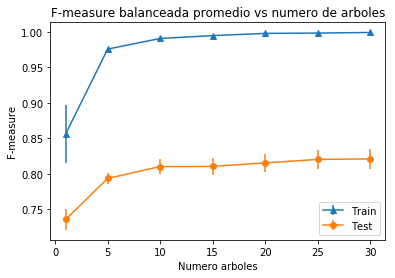

[0.73583122274069723,
 0.7935563773092702,
 0.81024582613945562,
 0.81043425914776679,
 0.8154171874481545,
 0.82030345704163943,
 0.82108366728438364]

In [119]:

#plt.plot(number_trees,mean_results_train)
plt.errorbar(number_trees,mean_results_train3,std_results_train3, marker='^',label="Train")

plt.errorbar(number_trees,mean_results_test3,std_results_test3,marker='o',label="Test")
plt.legend()
plt.title("F-measure balanceada promedio vs numero de arboles")
plt.xlabel("Numero arboles")
plt.ylabel("F-measure")
plt.show()
mean_results_test3

Si bien la teoría nos indica que Random Forest y Adaboost son algoritmos superiores a Bagging, en estos experimentos no se observa una diferencia sustancial entre estos. A medida que se aumenta la cantidad de árboles, todos los algoritmos llegan a un F-measure de 0.82 aproximadamente. Esto podría deberse a la naturaleza de la data en sí: 0.82 es el máximo que podría obtenerse dados los datos y las características, y es suficientemente fácil llegar a estos resultados utilizando ensamblados, independiente de cuál se use. En problemas más difíciles esperaríamos ver diferencias sustanciales entre los algoritmos: este no es el caso.

## (g)
Defina un criterio para estimar la importancia de los distintos atributos en el ensamblado de Random Forest, implementelo sobre alguno de los ensambladores entrenados en d), haga un ranking de
importancia de atributos ¿Es posible implementar este criterio sobre una técnica de boost como lo es
AdaBoost?

Se utilizará la implementación por defecto de sci-kit learn en Random Forest para generar la importancia de las características. Tal implementación se basa en calcular en cuánto disminuye, en promedio sobre todos los árboles, la medida de impureza al ser particionados los árboles sobre tal característica, y ponderado por la cantidad de datos afectados en la partición. Más aún, como hemos construido 20 conjuntos de train y test, podemos calcular la importancia promediada obtenida sobre cada conjunto de train, esperando que los resultados sean aún más representativos.

In [157]:
from sklearn.ensemble import RandomForestClassifier
number_trees = [1,5,10,15,20,25,30]
lambda_random_forest = lambda ne,ct,cw,md: RandomForestClassifier(n_estimators=ne,max_depth=md,class_weight=cw,criterion=ct)
mean_results_train = []
std_results_train = []
mean_results_test = []
std_results_test = []
importance = np.zeros((len(Train_sets),11))
for i in range(len(Train_sets)):
    parameter_list = [100,criterion[0],class_weight[0],max_depth[2]]
    #results_train,results_test,_ = train_and_test(Train_sets,Test_sets,Train_y,Test_y, parameter_list,lambda_random_forest,f_measure)
    clf = lambda_random_forest(*parameter_list)
    clf.fit(Train_sets[i],Train_y[i])
    #print("Scores características:", map(lambda x:round (x,11),
    #                                clf.feature_importances_))
    importance[i,:]=clf.feature_importances_
    
promedio = np.mean(importance,axis=0)
std = np.std(importance,axis=0)
index = np.argsort(promedio)
df.columns.values[index]
x = np.linspace(0,10,11)

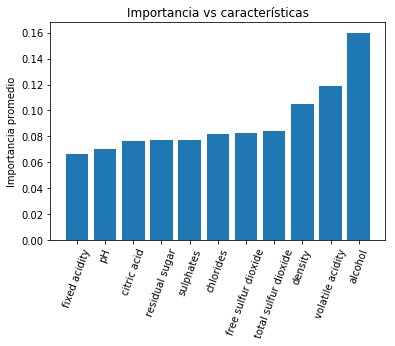

In [161]:
promedio = np.mean(importance,axis=0)
std = np.std(importance,axis=0)
index = np.argsort(promedio)
df.columns.values[index]
x = np.linspace(0,10,11)
plt.figure()
my_xticks = df.columns.values[index]
plt.xticks(x, my_xticks,rotation=70)
plt.bar(x,np.sort(promedio))
plt.ylabel("Importancia promedio")
plt.title("Importancia vs características")
plt.show()

Se observa que la característica más importante según el criterio es el alcohol, seguido de la acides volátil y la densidad. Luego, el resto de las características tiene una importancia promedio similar. A continuación se muestra la desviación estándar de la importancia obtenida de los atributos a través de los 20 conjuntos de train.

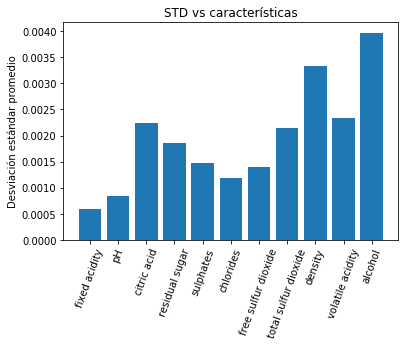

In [162]:
plt.figure()
my_xticks = df.columns.values[index]
plt.xticks(x, my_xticks,rotation=70)
plt.bar(x,std[index])
plt.ylabel("Desviación estándar promedio")
plt.title("STD vs características")
plt.show()

La desviación estándar promedio no varía demasiado. Está en el orden de -3, mientras que el promedio se mueve en el orden de -1, por lo cual la variación es mínima. Probablemente la distribución no presentó variaciones significativas entre los distintos conjuntos de entrenamiento, con lo cual uno era suficiente para poder estimar bien cuales son las características más importantes.

En cuanto a Adaboost, no se podría implementar este método debido a que los clasificadores en este algoritmo tienen un sesgo hacia ciertos datos (los mal clasificados del paso anterior) con lo que la importancia de las características estaría sesgada dependiendo del clasificador del ensamblado.

# 4. Reconocimiento de Imágenes Sign Gestures
MNIST es un dataset muy popular de dı́gitos escrito a mano que a servido para probar distintos algoritmos
de Machine Learning relacionados con Computer Vision. Buscando nuevos desafı́os, investigadores generaron
un dataset que podrı́a usarse eventualmente en aplicaciones reales, Sign Gestures, consta de imagenes del
lenguaje de señas, estas tienen una resolución de 28x28 pixeles representados en una escala de grises 0-255.
La versión utilizada se atribuye a [8] y viene separada en 27455 ejemplos de entrenamiento y 7172 casos de
pruebas. Las clases son mutualmente excluyentes y corresponden a las letras del alfabeto (ver imagen).

## (a)
Construya una función que cargue todos los datos de entrenamiento y pruebas del problema generando
como salida: (i) dos matrices $X_{tr}, Y_{tr}$, correspondientes a las imágenes y etiquetas de entrenamiento,
(ii) dos matrices $X_{t}, Y_{t}$, correspondientes a las imágenes y etiquetas de pruebas, y finalmente (iii) dos
matrices $X_{v}, Y_{v}$, correspondientes a imágenes y etiquetas que se usarán como conjunto de validación, es
decir para tomar decisiones de diseño acerca del modelo. Este último conjunto debe ser extraı́do desde
el conjunto de entrenamiento original y no debe superar las 7000 imágenes.

In [207]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


def load_data():
    
    train = pd.read_csv('sign_mnist_train.csv')
    test = pd.read_csv('sign_mnist_test.csv')
    y = train['label']
    y_test = test['label']
    train = train.drop(['label'],axis=1)
    test = test.drop(['label'],axis=1)
    
    X,X_val,y,y_val = train_test_split(train,y,test_size=0.2)

    return X,y,X_val,y_val,test,y_test
X,y,X_val,y_val,X_test,y_test = load_data()

In [209]:
print("Tamaño del train set: "+str(len(X)))
print("Tamaño del validation set: "+str(len(X_val)))
print("Tamaño del test set: "+str(len(X_test)))

Tamaño del train set: 21964
Tamaño del validation set: 5491
Tamaño del test set: 7172


Se construye una función que permite entrenar las redes neuronales de forma automática y así poder probar una gran combinación de parámetros.

In [60]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
import numpy as np
from keras import backend as K

def train_nn_model(layers,drop,optimizer,activation,epochs,batch_size,classes,X,y,verbose=0):
    
    layers = np.array(layers).astype(int)
    # layer es una lista, en la que layer[i] corresponde a la cantidad de neuronas de la capa i
    # siendo i=0 la primera capa oculta
    I = X.shape[1]
    # Construccion del modelo
    model= Sequential()
    model.add(Dropout(drop,input_shape=(I,)))
    model.add(Dense(layers[0],input_dim=I,activation=activation))
    
    # Se agregan cuantas capas hayan sido especificadas
    for i in range(len(layers)-1):
        
        model.add(Dense(layers[i+1], activation=activation))
    
    model.add(Dense(classes,activation='softmax'))
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    y_cat = to_categorical(y)
    #early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')
    
    # Entrentamiento del modelo
    model.fit(X,y_cat,epochs=epochs,batch_size=batch_size,verbose=verbose)
    
    # Prediccion y cálculo del error del modelo
    
    #predicted = np.argmax(model.predict(X_test), axis=1)
    
    #K.clear_session()
    return model
    
    

## (b)
Construya una función que escale apropiadamente las imágenes antes de trabajar. Experimente sólo
escalando los datos de acuerdo a la intensidad máxima de pixel (i.e., dividiendo por 255) y luego
centrando y escalándolos como en actividades anteriores.

In [8]:
from sklearn.preprocessing import StandardScaler


def scale_data(X,X_val,X_test):

    ssX = X/250.
    ssX_val = X_val/250.
    ssX_test = X_test/250.

    scaler = StandardScaler()
    sX = scaler.fit_transform(X)
    sX_val = scaler.transform(X_val)
    sX_test = scaler.transform(X_test)
    
    return ssX,ssX_val,ssX_test,sX,sX_val,sX_test
    


La función implementada escala los datos dividiendo por 250, y también los estandariza obteniendo la media y la desviación estándar a partir del Train set.

## (c)
Diseñe, entrene y evalúe una red neuronal para el problema partir de la representación original de las
imágenes. Experimente con distintas arquitecturas, pre-procesamientos y métodos de entrenamiento,
midiendo el error de clasificación sobre el conjunto de validación. En base a esta última medida de
desempeño, decida qué modelo, de entre todos los evaluados, medirá finalmente en el conjunto de test.
Reporte y discuta los resultados obtenidos. Se espera que logre obtener un error de pruebas menor o
igual a 0.2.

A continuación se mostrará que utilizar un set de validación es inútil en este problema en particular. Para ello, se mostrará cómo una red puede fácilmente llegar a un error de validación 0 a medida que ésta es entrenada, independiente del conjunto de validación que sea escogido.

In [17]:
parameter_list = [100,'adadelta','relu',20,100,25]
#layers,optimizer,activation,epochs,batch_size,classes,X,y
for i in range(10):
    X,y,X_val,y_val,X_test,y_test = load_data()
    ssX,ssX_val,ssX_test, sX, sX_val, sX_test = scale_data(X,X_val,X_test)
    model = train_nn_model([100],'adadelta','relu',10,100,25,sX,y)
    y_val_pred = np.argmax(model.predict(sX_val),axis=1)
    y_pred = np.argmax(model.predict(sX),axis=1)
    accuracy = np.mean(y_pred == y)
    val_accuracy = np.mean(y_val_pred == y_val)
    print("Accuracy sobre el train set "+str(i+1))
    print(accuracy)
    print("Accuracy sobre el validation set "+str(i+1))
    print(val_accuracy)
    

Accuracy sobre el train set 1
1.0
Accuracy sobre el validation set 1
1.0
Accuracy sobre el train set 2
1.0
Accuracy sobre el validation set 2
1.0
Accuracy sobre el train set 3
1.0
Accuracy sobre el validation set 3
1.0
Accuracy sobre el train set 4
1.0
Accuracy sobre el validation set 4
1.0
Accuracy sobre el train set 5
1.0
Accuracy sobre el validation set 5
1.0
Accuracy sobre el train set 6
1.0
Accuracy sobre el validation set 6
1.0
Accuracy sobre el train set 7
1.0
Accuracy sobre el validation set 7
1.0
Accuracy sobre el train set 8
1.0
Accuracy sobre el validation set 8
1.0
Accuracy sobre el train set 9
1.0
Accuracy sobre el validation set 9
1.0
Accuracy sobre el train set 10
1.0
Accuracy sobre el validation set 10
1.0


Observamos claramente como, con la data escalada de forma sencilla, la red es capaz con tan sólo 10 iteraciones de aprender perfectamente la distribución asociada a los datos de entrenamiento y validación. Esto nos sugiere dos posibilidades: 
- La distribución de los datos es extremadamente sencilla (con datos posiblemente repetidos o que varían muy poco unos de otros en las distintas clases).
- El train set tiene datos seleccionados de tal manera que las distintas clases se pueden aprender de manera muy sencilla, pero que sin embargo no se corresponde con la distribución presente en la realidad.

La primera opción nos llevaría a simplemente utilizar la red que aprendió prefectamente la distribución de los datos y esperar un error de test de 0%. Sin embargo, debido a que los datos son imágenes, creemos que la segunda opción es más pausible. Por ende, la opción a seguir acá es construir un clasificador que no sobre-ajuste sobre el train set, sin tener en cuenta el set de validación, y esperar a que éste prediga decentemente sobre la data de test.

Ahora, debido a que se nos pide llegar a un error de 0.2 aproximadamente, no nos queda más que utilizar el test set para poder validar los parámetros escogidos.

### Red neuronal con data sin escalar

In [90]:
import itertools
layers = [10,50,100,150]
dropouts = [0.3,0.5,0.7]
X,y,X_val,y_val,X_test,y_test = load_data()
ssX,ssX_val,ssX_test, sX, sX_val, sX_test = scale_data(X,X_val,X_test)

for i in range(len(layers)):
    for j in range(len(dropouts)):

        model = train_nn_model([layers[i]],dropouts[j],'adadelta','relu',50,100,25,X.values,y,verbose=0)

        y_pred = np.argmax(model.predict(X.values),axis=1)
        y_test_pred = np.argmax(model.predict(X_test.values),axis=1)
        accuracy = np.mean(y_pred == y)
        test_accuracy = np.mean(y_test_pred == y_test)
        print("Accuracy sobre el train set con "+str(layers[i])+" neuronas ocultas y dropout de "+str(dropouts[j]))
        print(accuracy)
        print("Accuracy sobre el test set "+str(layers[i])+" neuronas ocultas y dropout de "+str(dropouts[j]))
        print(test_accuracy)
    

Accuracy sobre el train set con 10 neuronas ocultas y dropout de 0.3
0.0477144418139
Accuracy sobre el test set 10 neuronas ocultas y dropout de 0.3
0.0200780814278
Accuracy sobre el train set con 10 neuronas ocultas y dropout de 0.5
0.0477144418139
Accuracy sobre el test set 10 neuronas ocultas y dropout de 0.5
0.0200780814278
Accuracy sobre el train set con 10 neuronas ocultas y dropout de 0.7
0.0477144418139
Accuracy sobre el test set 10 neuronas ocultas y dropout de 0.7
0.0200780814278
Accuracy sobre el train set con 50 neuronas ocultas y dropout de 0.3
0.137907484975
Accuracy sobre el test set 50 neuronas ocultas y dropout de 0.3
0.124093697713
Accuracy sobre el train set con 50 neuronas ocultas y dropout de 0.5
0.143188854489
Accuracy sobre el test set 50 neuronas ocultas y dropout de 0.5
0.140267707752
Accuracy sobre el train set con 50 neuronas ocultas y dropout de 0.7
0.120788563103
Accuracy sobre el test set 50 neuronas ocultas y dropout de 0.7
0.0913273842722
Accuracy sobre 

Tal y como se podría esperar, al entrenar con la data sin escalar de ninguna manera, la red no es capaz de aprender absolutamente nada, produciendo accuracies cercanas a 0.02, cuando si eligieramos las clases aleatoriamente, se debería obtener un accuracy de 0.04 (1/24). El problema es que ciertos píxeles tienen intensidades mucho mayores que otros, por lo que la influencia de éstos claramente enmascara la influencia de aquellos píxeles de menor intensidad pero que podrían ser aún más importantes. La red tiene problemas entonces en calcular los pesos , con un mismo learning rate, con tal de balancear la influencia de los píxeles con distinta intensidad máxima.

### Red entrenada con escalamiento sencillo  (dividir por 255) de datos

In [121]:
import itertools
layers = [10,50,100,150]
dropouts = [0.3,0.5,0.7]
X,y,X_val,y_val,X_test,y_test = load_data()
ssX,ssX_val,ssX_test, sX, sX_val, sX_test = scale_data(X,X_val,X_test)

for i in range(len(layers)):
    for j in range(len(dropouts)):

        model = train_nn_model([layers[i]],dropouts[j],'adadelta','relu',50,100,25,sX,y,verbose=0)

        y_pred = np.argmax(model.predict(sX),axis=1)
        y_test_pred = np.argmax(model.predict(sX_test),axis=1)
        accuracy = np.mean(y_pred == y)
        test_accuracy = np.mean(y_test_pred == y_test)
        print("Accuracy sobre el train set con "+str(layers[i])+" neuronas ocultas y dropout de "+str(dropouts[j]))
        print(accuracy)
        print("Accuracy sobre el test set "+str(layers[i])+" neuronas ocultas y dropout de "+str(dropouts[j]))
        print(test_accuracy)
    

Accuracy sobre el train set con 10 neuronas ocultas y dropout de 0.3
0.924786013477
Accuracy sobre el test set 10 neuronas ocultas y dropout de 0.3
0.661042944785
Accuracy sobre el train set con 10 neuronas ocultas y dropout de 0.5
0.847477690767
Accuracy sobre el test set 10 neuronas ocultas y dropout de 0.5
0.607640825432
Accuracy sobre el train set con 10 neuronas ocultas y dropout de 0.7
0.777271899472
Accuracy sobre el test set 10 neuronas ocultas y dropout de 0.7
0.605549358617
Accuracy sobre el train set con 50 neuronas ocultas y dropout de 0.3
1.0
Accuracy sobre el test set 50 neuronas ocultas y dropout de 0.3
0.797685443391
Accuracy sobre el train set con 50 neuronas ocultas y dropout de 0.5
1.0
Accuracy sobre el test set 50 neuronas ocultas y dropout de 0.5
0.812186279978
Accuracy sobre el train set con 50 neuronas ocultas y dropout de 0.7
0.996767437625
Accuracy sobre el test set 50 neuronas ocultas y dropout de 0.7
0.814696040156
Accuracy sobre el train set con 100 neuronas

En este caso, con el escalamiento sencillo ya se obtienen accuracies mayores a 0.8 para el test set. En particular, con 150 neuronas ocultas en la capa escondida y un dropout de 0.5 ya se obtiene 0.85. El escalamiento realizado claramente reduce el problema de las intensidades máximas, aunque no todas éstas se encuentren en el rango [0,1]. Posiblemente, la diferencia radica en la magnitud de los pesos de la red neuronal: debido a que los pesos de la red están en el rango [0,1] inicialmente y se tiene un learning rate constante (que determina cuánto debería aumentar o disminuir un peso en particular), es más fácil que en el entrenamiento los pesos se ajusten para compensar la diferencia de magnitud cuando los valores de las características son del mismo orden que los valores de los pesos. 

Por otro lado, el hecho de que un dropout de 0.5 sea útil en esta tarea indica que existen muchas características correlacionadas que pueden llevar a realizar overfitting cuando son tomados todas en conjunto. Esto era de esperar, ya que las imágenes están plagadas de píxeles altamente correlacionados que no inducen patrones útiles para la tarea de clasificación (por ejemplo, el fondo de las imágenes con las que estamos trabajando son píxeles inútiles para la tarea).

### Red neuronal entrenada con estandarización de datos

In [61]:
import itertools
layers = [10,50,100,150]
dropouts = [0.3,0.5,0.7]


for i in range(len(layers)):
    for j in range(len(dropouts)):

        model = train_nn_model([layers[i]],dropouts[j],'adadelta','relu',50,100,25,ssX.values,y,verbose=0)

        y_pred = np.argmax(model.predict(ssX.values),axis=1)
        y_test_pred = np.argmax(model.predict(ssX_test.values),axis=1)
        accuracy = np.mean(y_pred == y)
        test_accuracy = np.mean(y_test_pred == y_test)
        print("Accuracy sobre el train set con "+str(layers[i])+" neuronas ocultas y dropout de "+str(dropouts[j]))
        print(accuracy)
        print("Accuracy sobre el test set "+str(layers[i])+" neuronas ocultas y dropout de "+str(dropouts[j]))
        print(test_accuracy)
    

Accuracy sobre el train set con 10 neuronas ocultas y dropout de 0.3
0.547942087052
Accuracy sobre el test set 10 neuronas ocultas y dropout de 0.3
0.494701617401
Accuracy sobre el train set con 10 neuronas ocultas y dropout de 0.5
0.483973775269
Accuracy sobre el test set 10 neuronas ocultas y dropout de 0.5
0.463608477412
Accuracy sobre el train set con 10 neuronas ocultas y dropout de 0.7
0.386769258787
Accuracy sobre el test set 10 neuronas ocultas y dropout de 0.7
0.368098159509
Accuracy sobre el train set con 50 neuronas ocultas y dropout de 0.3
0.793753414679
Accuracy sobre el test set 50 neuronas ocultas y dropout de 0.3
0.641662018963
Accuracy sobre el train set con 50 neuronas ocultas y dropout de 0.5
0.725733017665
Accuracy sobre el test set 50 neuronas ocultas y dropout de 0.5
0.587702175125
Accuracy sobre el train set con 50 neuronas ocultas y dropout de 0.7
0.587871061737
Accuracy sobre el test set 50 neuronas ocultas y dropout de 0.7
0.51352481874
Accuracy sobre el train

Se observa que el mejor resultado sobre el test set (accuracy de 0.78) se obtiene con 150 unidades ocultas y un dropout de 0.3. Para buscar mejorar el error, se agregará una capa oculta extra a ese modelo.

In [65]:
import itertools
layers = [10,50,100,150]
#dropouts = [0.3,0.5,0.7]


for i in range(len(layers)):
        
        model = train_nn_model([150,layers[i]],0.3,'adadelta','relu',50,100,25,ssX.values,y,verbose=0)

        y_pred = np.argmax(model.predict(ssX.values),axis=1)
        y_test_pred = np.argmax(model.predict(ssX_test.values),axis=1)
        accuracy = np.mean(y_pred == y)
        test_accuracy = np.mean(y_test_pred == y_test)
        print("Accuracy sobre el train set con 1 capa de 150 y otra de "+str(layers[i])+" neuronas ocultas y dropout de 0.5")
        print(accuracy)
        print("Accuracy sobre el test set con 1 capa de 150 y otra de "+str(layers[i])+" neuronas ocultas y dropout de 0.5")
        print(test_accuracy)

Accuracy sobre el train set con 1 capa de 150 y otra de 10 neuronas ocultas y dropout de 0.5
0.774312511382
Accuracy sobre el test set con 1 capa de 150 y otra de 10 neuronas ocultas y dropout de 0.5
0.656441717791
Accuracy sobre el train set con 1 capa de 150 y otra de 50 neuronas ocultas y dropout de 0.5
0.898242578765
Accuracy sobre el test set con 1 capa de 150 y otra de 50 neuronas ocultas y dropout de 0.5
0.746514221974
Accuracy sobre el train set con 1 capa de 150 y otra de 100 neuronas ocultas y dropout de 0.5
0.94777818248
Accuracy sobre el test set con 1 capa de 150 y otra de 100 neuronas ocultas y dropout de 0.5
0.756692693809
Accuracy sobre el train set con 1 capa de 150 y otra de 150 neuronas ocultas y dropout de 0.5
0.956656346749
Accuracy sobre el test set con 1 capa de 150 y otra de 150 neuronas ocultas y dropout de 0.5
0.79615170106


Se observa que el mejor resultado (accuracy de 0.795), nuevamente, se obtiene cuando se agrega otra capa oculta con 150 unidades. Se volverá a agregar una última capa para ver si los resultados pueden mejorar aún más.

In [66]:
layers = [10,50,100,150]
#dropouts = [0.3,0.5,0.7]


for i in range(len(layers)):
        
        model = train_nn_model([150,150,layers[i]],0.3,'adadelta','relu',50,100,25,ssX.values,y,verbose=0)

        y_pred = np.argmax(model.predict(ssX.values),axis=1)
        y_test_pred = np.argmax(model.predict(ssX_test.values),axis=1)
        accuracy = np.mean(y_pred == y)
        test_accuracy = np.mean(y_test_pred == y_test)
        print("Accuracy sobre el train set con 2 capas de 150 y otra de "+str(layers[i])+" neuronas ocultas y dropout de 0.3")
        print(accuracy)
        print("Accuracy sobre el test set con 2 capas de 150 y otra de "+str(layers[i])+" neuronas ocultas y dropout de 0.3")
        print(test_accuracy)

Accuracy sobre el train set con 2 capas de 150 y otra de 10 neuronas ocultas y dropout de 0.3
0.875842287379
Accuracy sobre el test set con 2 capas de 150 y otra de 10 neuronas ocultas y dropout de 0.3
0.72824874512
Accuracy sobre el train set con 2 capas de 150 y otra de 50 neuronas ocultas y dropout de 0.3
0.955973411036
Accuracy sobre el test set con 2 capas de 150 y otra de 50 neuronas ocultas y dropout de 0.3
0.79489682097
Accuracy sobre el train set con 2 capas de 150 y otra de 100 neuronas ocultas y dropout de 0.3
0.950418867237
Accuracy sobre el test set con 2 capas de 150 y otra de 100 neuronas ocultas y dropout de 0.3
0.760596765198
Accuracy sobre el train set con 2 capas de 150 y otra de 150 neuronas ocultas y dropout de 0.3
0.971134583865
Accuracy sobre el test set con 2 capas de 150 y otra de 150 neuronas ocultas y dropout de 0.3
0.797406581149


Finalmente, se vuelve a obtener un mejor resultado con la tercera capa oculta de 150 unidades. Aún así, en este caso los resultados en general fueron peores que con la data con escalamiento sencillo, a pesar de la incorporación de múltiples capas ocultas. Esto podría deberse a que, coincidentemente, aquellos píxeles que no varían mucho su intensidad no son tan importantes realmente a la hora de la clasificación (como por ejemplo, los píxeles del fondo de la imagen). Entonces, al ser escalados tan sólo dividiendo por 255, los valores de éstos permanecen en un rango muy pequeño y el efecto en la variación de estos píxeles no influye mucho en el resultado final de la red (se debe tener en cuenta que de capa en capa la influencia de una variable se va magnificando dependiendo de los pesos asociados). En cambio, al colocar aquellos píxeles que poco varían en el rango [0,1], una variación despreciable en la realidad de éstos podría provocar cambios sustanciales en el resultado final de la red, debido a que todas las variables se mueven en dicho rango, teniendo como consecuencia final una mayor dificultad en el entrenamiento de la red para que ésta pueda discernir entre aquellos píxeles que importan y aquellos que no.

## (d)
Para la mejor red entrenada anteriormente construya la matriz de confusión de las distintas clases, para
asi visualizar cuáles son las clases más difı́ciles de clasificar y con cuáles se confunden. Comente.

El código a utilizar está directamente sacado de stack-overflow.

7172/7172 [==============================] - 2s 210us/step


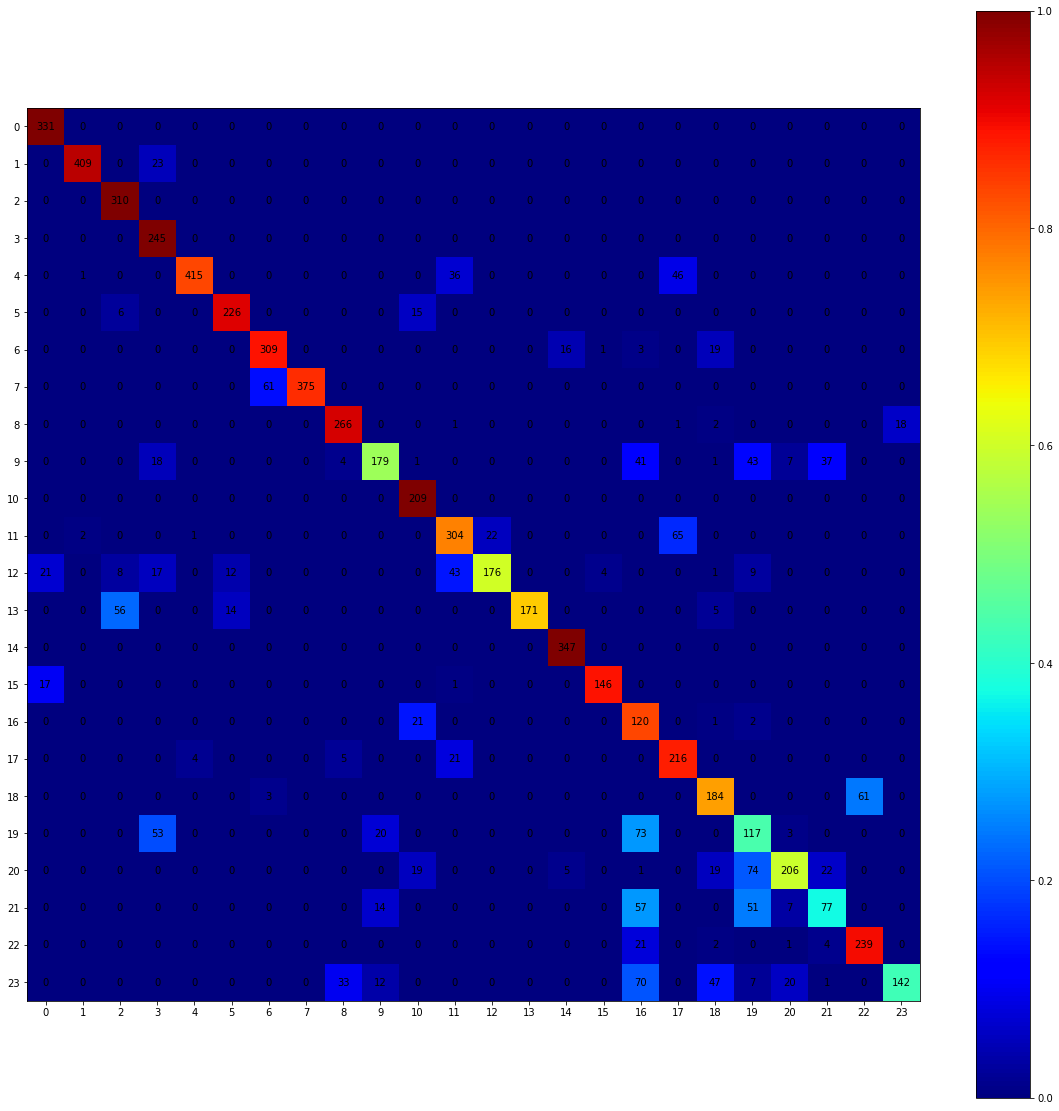

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_test = model.predict_classes(ssX_test.values)
cnf_matrix = confusion_matrix(y_test,y_pred_test)

norm_conf = []
for i in cnf_matrix:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure(figsize=(20,20))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = cnf_matrix.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(cnf_matrix[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
#alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
plt.xticks(range(width), range(width),)
plt.yticks(range(height), range(height))
plt.show()
# https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python

Se observa claramente que, por ejemplo, cuando se trata de predecir la letra "U", el algoritmo se confunde y en muchos casos predice la letra "R" o la letra "D".

<img src="D-R-U.png">

Asimismo, cuando se trata de predecir "W", el algoritmo se confunde muchas veces con "U" y con "R".

<img src="R-U-W.png">

En general, hay varias complicaciones con la "U" y "R" debido a que muchos signos son parecidos, por lo cual es normal que el algoritmo se "confunda", ya que la diferencia está sólo en una pequeña porción de píxeles.

## (e)
Entrene una SVM no lineal sobre los pixeles con y sin pre-procesamiento. Puede utilizar el conjunto de
validación para seleccionar hiper-parámetros, como el nivel de regularización aplicado y/o la función
de kernel a utilizar.

En este caso los experimentos fueron realizados en el cluster del CCTVAL por razones de tiempo computacional. Se muestra a continuación las funciones que fueron implementadas para los experimentos y se copian directamente los resultados obtenidos más abajo.

Los parámetros que se probaron fueron:

- C: 0.1, 1, 10
- Kernel: Cúbico, Gaussiano

### SVM con data sin pre-procesar

In [68]:
from sklearn.svm import SVC
lambda_svc = lambda c,k: SVC(C=int(c),kernel=k)

In [ ]:
c = [0.1,1.,10.]
k = ['rbf','poly']


for i in range(len(c)):
    for j in range(len(k)):
        
        #model = train_nn_model([150,layers[i]],dropouts[j],'adadelta','relu',50,100,25,ssX.values,y,verbose=0)
        clf = SVC(C=float(c[i]),kernel=str(k[j]))
        clf.fit(ssX.values,y.values)
        y_pred = clf.predict(ssX.values)
        y_test_pred = clf.predict(ssX_test.values)
        
        accuracy = np.mean(y_pred == y)
        test_accuracy = np.mean(y_test_pred == y_test)
        print("Accuracy sobre el train set con C "+str(c[i])+"  y kernel de " +k[j])
        print(accuracy)
        print("Accuracy sobre el test set con  C "+str(c[i])+"  y kernel de " +k[j])
        print(test_accuracy)

Accuracy sobre el train set con C 0.1  y kernel de rbf

0.0471316700055

Accuracy sobre el test set con  C 0.1  y kernel de rbf

0.0200780814278

Accuracy sobre el train set con C 0.1  y kernel de poly

1.0

Accuracy sobre el test set con  C 0.1  y kernel de poly

0.781790295594

Accuracy sobre el train set con C 1.0  y kernel de rbf

1.0

Accuracy sobre el test set con  C 1.0  y kernel de rbf

0.0200780814278

Accuracy sobre el train set con C 1.0  y kernel de poly

1.0

Accuracy sobre el test set con  C 1.0  y kernel de poly

0.781790295594

Accuracy sobre el train set con C 10.0  y kernel de rbf

1.0

Accuracy sobre el test set con  C 10.0  y kernel de rbf

0.0200780814278

Accuracy sobre el train set con C 10.0  y kernel de poly

1.0

Accuracy sobre el test set con  C 10.0  y kernel de poly

0.781790295594


Se observa que se obtuvieron resultados pésimos con kernel Gaussiano y buenos resultados con kernel polinomial. Es difícil entender qué sucede realmente con la transformación de dichos kernels, pero quizás el efecto asociado al no escalamiento se ve aminorado por la utilización de las transformaciones asociadas.

### SVM con data con escalamiento sencillo (dividir por 255)

Accuracy sobre el train set con C 0.1  y kernel de rbf

0.430522673466

Accuracy sobre el test set con  C 0.1  y kernel de rbf

0.333658672616

Accuracy sobre el train set con C 0.1  y kernel de poly

0.147914769623

Accuracy sobre el test set con  C 0.1  y kernel de poly

0.0870050195204

Accuracy sobre el train set con C 1.0  y kernel de rbf

0.848916408669

Accuracy sobre el test set con  C 1.0  y kernel de rbf

0.701756832125

Accuracy sobre el train set con C 1.0  y kernel de poly

0.627754507376

Accuracy sobre el test set con  C 1.0  y kernel de poly

0.515058561071

Accuracy sobre el train set con C 10.0  y kernel de rbf

0.9974139501

Accuracy sobre el test set con  C 10.0  y kernel de rbf

0.775515895148

Accuracy sobre el train set con C 10.0  y kernel de poly

0.94317974868

Accuracy sobre el test set con  C 10.0  y kernel de poly

0.756553262688

Los resultados mejoran considerablemente con el pre-procesamiento sencillo. En particular, para el kernel gaussiano la mejora es sustancial: de 0.02 de accuracy se aumenta a 0.77.

In [92]:

c = [0.1,1.,10.]
k = ['rbf','poly']


for i in range(len(c)):
    for j in range(len(k)):
        
        #model = train_nn_model([150,layers[i]],dropouts[j],'adadelta','relu',50,100,25,ssX.values,y,verbose=0)
        clf = SVC(C=float(c[i]),kernel=str(k[j]))
        clf.fit(ssX.values,y.values)
        y_pred = clf.predict(ssX.values)
        y_test_pred = clf.predict(ssX_test.values)
        
        accuracy = np.mean(y_pred == y)
        test_accuracy = np.mean(y_test_pred == y_test)
        print("Accuracy sobre el train set con C "+str(c[i])+"  y kernel de " +k[j])
        print(accuracy)
        print("Accuracy sobre el test set con  C "+str(c[i])+"  y kernel de " +k[j])
        print(test_accuracy)

Accuracy sobre el train set con C 0.1  y kernel de rbf

0.944053906392

Accuracy sobre el test set con  C 0.1  y kernel de rbf

0.774261015059

Accuracy sobre el train set con C 0.1  y kernel de poly

0.740702968494

Accuracy sobre el test set con  C 0.1  y kernel de poly

0.537228109314

Accuracy sobre el train set con C 1.0  y kernel de rbf

1.0

Accuracy sobre el test set con  C 1.0  y kernel de rbf

0.848856664808

Accuracy sobre el train set con C 1.0  y kernel de poly

0.988235294118

Accuracy sobre el test set con  C 1.0  y kernel de poly

0.781372002231

Accuracy sobre el train set con C 10.0  y kernel de rbf

1.0

Accuracy sobre el test set con  C 10.0  y kernel de rbf

0.851645287228

Accuracy sobre el train set con C 10.0  y kernel de poly

1.0

Accuracy sobre el test set con  C 10.0  y kernel de poly

0.82194645845

Como se observa a partir de los resultados, la mejor combinación se obtiene con C=10 y kernel gaussiano, obteniéndose una accuracy de 0.85, casi el mismo resultado que se obtiene con la mejor red neuronal de la sección anterior. Es interesante que con C=10 y el kernel gaussiano, el conjunto de training es clasificado perfectamente y aún así se obtienen los mejores resultados: uno esperaría que el overfitting generado se refleje en una peor capacidad de generalización. Sin embargo, al parecer el dataset es bastante sencillo y por eso no se evidencia este fenómeno.

## (f)
Entrene una árbol de clasificación sobre los pixeles con y sin pre-procesamiento. Puede utilizar el
conjunto de validación para seleccionar hiper-parámetros, como la profundidad máxima del árbol.

Los parámetros que se consideraron para el árbol son:

- Impureza : Gino o Entropía
- Máxima profundidad : 10, 20, 50, 100, 150, 200

## Decision Tree con data sin pre-procesar

In [91]:
from sklearn.tree import DecisionTreeClassifier

ct = ["gini","entropy"]
md = [10,20,50,100,150,200]


for i in range(len(ct)):
        for k in range(len(md)):
        
            #model = train_nn_model([150,layers[i]],dropouts[j],'adadelta','relu',50,100,25,ssX.values,y,verbose=0)
            clf = DecisionTreeClassifier(criterion=ct[i],max_depth=md[k])
            clf.fit(X.values,y.values)
            y_pred = clf.predict(X.values)
            y_test_pred = clf.predict(X_test.values)

            accuracy = np.mean(y_pred == y)
            test_accuracy = np.mean(y_test_pred == y_test)
            palabra = "con"
            if j==0:
                palabra = "sin"
            print("Accuracy sobre el train set con criterio "+str(ct[i])+"y máxima profundidad "+str(md[k]))
            print(accuracy)
            print("Accuracy sobre el test set con criterio "+str(ct[i])+"y máxima profundidad "+str(md[k]))
            print(test_accuracy)

Accuracy sobre el train set con criterio giniy máxima profundidad 10
0.619695865962
Accuracy sobre el test set con criterio giniy máxima profundidad 10
0.320552147239
Accuracy sobre el train set con criterio giniy máxima profundidad 20
0.955290475323
Accuracy sobre el test set con criterio giniy máxima profundidad 20
0.439626324596
Accuracy sobre el train set con criterio giniy máxima profundidad 50
1.0
Accuracy sobre el test set con criterio giniy máxima profundidad 50
0.454545454545
Accuracy sobre el train set con criterio giniy máxima profundidad 100
1.0
Accuracy sobre el test set con criterio giniy máxima profundidad 100
0.462771890686
Accuracy sobre el train set con criterio giniy máxima profundidad 150
1.0
Accuracy sobre el test set con criterio giniy máxima profundidad 150
0.454545454545
Accuracy sobre el train set con criterio giniy máxima profundidad 200
1.0
Accuracy sobre el test set con criterio giniy máxima profundidad 200
0.454406023424
Accuracy sobre el train set con crit

Se observa que el accuracy de los modelos no supera 0.45 en ningún caso, aún cuando el train set es clasificado perfectamente. La frontera de clasificación debe ser, entonces, demasiado específica a los datos de entrenamiento y no generaliza bien. En el caso de la SVM se observaba que si bien se obtenía accuracy 1 en el train set, en el test set también se obtenían buenos resultados, debido a que la frontera de decisión, si bien es no lineal, es lo suficientemente sesgada ( un hiperplano en el espacio de las características transformadas) como para que no se produzca el overfitting que se produce acá.

### Decision Tree con data con escalamiento sencillo (dividir por 255)

In [164]:
from sklearn.tree import DecisionTreeClassifier

ct = ["gini","entropy"]
md = [10,20,50,100,150,200]


for i in range(len(ct)):
        for k in range(len(md)):
        
            #model = train_nn_model([150,layers[i]],dropouts[j],'adadelta','relu',50,100,25,ssX.values,y,verbose=0)
            clf = DecisionTreeClassifier(criterion=ct[i],max_depth=md[k])
            clf.fit(sX,y)
            y_pred = clf.predict(sX)
            y_test_pred = clf.predict(sX_test)

            accuracy = np.mean(y_pred == y)
            test_accuracy = np.mean(y_test_pred == y_test)
            palabra = "con"
            if j==0:
                palabra = "sin"
            print("Accuracy sobre el train set con criterio "+str(ct[i])+"y máxima profundidad "+str(md[k]))
            print(accuracy)
            print("Accuracy sobre el test set con criterio "+str(ct[i])+"y máxima profundidad "+str(md[k]))
            print(test_accuracy)

Accuracy sobre el train set con criterio giniy máxima profundidad 10
0.62620651976
Accuracy sobre el test set con criterio giniy máxima profundidad 10
0.34509202454
Accuracy sobre el train set con criterio giniy máxima profundidad 20
0.968311782918
Accuracy sobre el test set con criterio giniy máxima profundidad 20
0.432515337423
Accuracy sobre el train set con criterio giniy máxima profundidad 50
1.0
Accuracy sobre el test set con criterio giniy máxima profundidad 50
0.437813720022
Accuracy sobre el train set con criterio giniy máxima profundidad 100
1.0
Accuracy sobre el test set con criterio giniy máxima profundidad 100
0.450641383157
Accuracy sobre el train set con criterio giniy máxima profundidad 150
1.0
Accuracy sobre el test set con criterio giniy máxima profundidad 150
0.449386503067
Accuracy sobre el train set con criterio giniy máxima profundidad 200
1.0
Accuracy sobre el test set con criterio giniy máxima profundidad 200
0.440741773564
Accuracy sobre el train set con criter

### Decision Tree con data con estandarización

In [165]:
from sklearn.tree import DecisionTreeClassifier

ct = ["gini","entropy"]
md = [10,20,50,100,150,200]


for i in range(len(ct)):
        for k in range(len(md)):
        
            #model = train_nn_model([150,layers[i]],dropouts[j],'adadelta','relu',50,100,25,ssX.values,y,verbose=0)
            clf = DecisionTreeClassifier(criterion=ct[i],max_depth=md[k])
            clf.fit(ssX.values,y.values)
            y_pred = clf.predict(ssX.values)
            y_test_pred = clf.predict(ssX_test.values)

            accuracy = np.mean(y_pred == y)
            test_accuracy = np.mean(y_test_pred == y_test)
            palabra = "con"
            if j==0:
                palabra = "sin"
            print("Accuracy sobre el train set con criterio "+str(ct[i])+"y máxima profundidad "+str(md[k]))
            print(accuracy)
            print("Accuracy sobre el test set con criterio "+str(ct[i])+"y máxima profundidad "+str(md[k]))
            print(test_accuracy)

Accuracy sobre el train set con criterio giniy máxima profundidad 10
0.62620651976
Accuracy sobre el test set con criterio giniy máxima profundidad 10
0.336726157278
Accuracy sobre el train set con criterio giniy máxima profundidad 20
0.968311782918
Accuracy sobre el test set con criterio giniy máxima profundidad 20
0.440044617959
Accuracy sobre el train set con criterio giniy máxima profundidad 50
1.0
Accuracy sobre el test set con criterio giniy máxima profundidad 50
0.439905186838
Accuracy sobre el train set con criterio giniy máxima profundidad 100
1.0
Accuracy sobre el test set con criterio giniy máxima profundidad 100
0.447295036252
Accuracy sobre el train set con criterio giniy máxima profundidad 150
1.0
Accuracy sobre el test set con criterio giniy máxima profundidad 150
0.451756832125
Accuracy sobre el train set con criterio giniy máxima profundidad 200
1.0
Accuracy sobre el test set con criterio giniy máxima profundidad 200
0.446179587284
Accuracy sobre el train set con crite

Se observa claramente que los resultados son mucho peores con el árbol de clasificación en todos los casos. Apenas se observó que los resultados eran deficientes con la data sin escalar, se esperaba que los resultados fueran idénticos para la data pre-procesada: para los árboles de clasificación, este tipo de preprocesamiento no tiene sentido ya que los algoritmos construyen una división en cada característica independientemente del rango en la que éstas se encuentran.